In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *
from Bucket import *

In [8]:
df = pd.read_csv(os.path.join(ppath, 'data', 'flights', 'flights.csv'))
df.describe()

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight,air_time,distance,hour,minute
count,336776.000000,336776.0,336776.000000,336776.000000,328521.000000,336776.000000,328521.000000,328063.000000,336776.000000,327346.000000,336776.000000,327346.000000,336776.000000,336776.000000,336776.000000
mean,168387.500000,2013.0,6.548510,15.710787,1349.109947,1344.254840,12.639070,1502.054999,1536.380220,6.895377,1971.923620,150.686460,1039.912604,13.180247,26.230100
std,97219.001466,0.0,3.414457,8.768607,488.281791,467.335756,40.210061,533.264132,497.457142,44.633292,1632.471938,93.688305,733.233033,4.661316,19.300846
min,0.000000,2013.0,1.000000,1.000000,1.000000,106.000000,-43.000000,1.000000,1.000000,-86.000000,1.000000,20.000000,17.000000,1.000000,0.000000
25%,84193.750000,2013.0,4.000000,8.000000,907.000000,906.000000,-5.000000,1104.000000,1124.000000,-17.000000,553.000000,82.000000,502.000000,9.000000,8.000000
50%,168387.500000,2013.0,7.000000,16.000000,1401.000000,1359.000000,-2.000000,1535.000000,1556.000000,-5.000000,1496.000000,129.000000,872.000000,13.000000,29.000000
75%,252581.250000,2013.0,10.000000,23.000000,1744.000000,1729.000000,11.000000,1940.000000,1945.000000,14.000000,3465.000000,192.000000,1389.000000,17.000000,44.000000
max,336775.000000,2013.0,12.000000,31.000000,2400.000000,2359.000000,1301.000000,2400.000000,2359.000000,1272.000000,8500.000000,695.000000,4983.000000,23.000000,59.000000


In [117]:
# order by scheduled departure time
df = df.sort_values(by='sched_dep_time', ascending=False)
df.head()

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
177365,177365,2013,4,13,2355.0,2359,-4.0,340.0,339,1.0,...,727,N535JB,JFK,BQN,201.0,1576,23,59,2013-04-13 23:00:00,JetBlue Airways
148339,148339,2013,3,13,2350.0,2359,-9.0,342.0,338,4.0,...,727,N643JB,JFK,BQN,202.0,1576,23,59,2013-03-13 23:00:00,JetBlue Airways
88958,88958,2013,12,6,2357.0,2359,-2.0,454.0,445,9.0,...,745,N584JB,JFK,PSE,204.0,1617,23,59,2013-12-06 23:00:00,JetBlue Airways
255716,255716,2013,7,7,20.0,2359,21.0,415.0,344,31.0,...,1503,N589JB,JFK,SJU,205.0,1598,23,59,2013-07-07 23:00:00,JetBlue Airways
308514,308514,2013,8,30,2358.0,2359,-1.0,334.0,344,-10.0,...,1503,N564JB,JFK,SJU,197.0,1598,23,59,2013-08-30 23:00:00,JetBlue Airways


In [125]:
def zero_pad_vectors(v1, v2):
    # Identify the length of the longer vector
    max_len = max(len(v1), len(v2))

    # Pad each vector with zeros at the end to match the length of the longer vector
    v1_padded = np.pad(v1, (0, max_len - len(v1)), 'constant')
    v2_padded = np.pad(v2, (0, max_len - len(v2)), 'constant')

    return v1_padded, v2_padded

In [179]:
gpt_bins = {'bins':list(range(0, 25, 4)),
     'gpt': 0.0}
binnings = [
    {'bins':list(range(0, 25, 1)),
     'gpt': 0.2,
     'labels': ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23', '23-24']},
    {'bins':list(range(0, 25, 2)),
     'gpt': 0.1,
     'labels': ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-24']},
    {'bins':list(range(0, 25, 3)),
     'gpt': 0.4,
     'labels': ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']},
    {'bins':list(range(0, 25, 4)),
     'gpt': 0.0,
     'labels': ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']},
    {'bins':list(range(0, 25, 6)),
     'gpt': 0.4,
     'labels': ['0-6', '6-12', '12-18', '18-24']},
    {'bins':list(range(0, 25, 8)),
     'gpt': 0.7,
     'labels': ['0-8', '8-16', '16-24']},
    {'bins':list(range(0, 25, 12)),
    'gpt': 0.8,
    'labels': ['0-12', '12-24']},
    {'bins':[0, 4, 8, 24],
    'gpt': 0.6,
    'labels': ['0-4', '4-8', '8-24']},
    {'bins':[0, 6, 8, 12, 16, 20, 24],
    'gpt': 0.8,
    'labels': ['0-6', '6-8', '8-12', '12-16', '16-20', '20-24']},
]

In [202]:
from scipy.stats import spearmanr, f_oneway

# Populate the dictionary with stats
for i in range(len(binnings)):
    data = df.copy()
    data['dep_delay'] = data['dep_delay'].replace(np.nan, 0)
    # Calculate L2 norm between each binning and gpt binning
    x = np.array(binnings[i]['bins'])
    y = np.array(gpt_bins['bins'])
    x, y = zero_pad_vectors(x, y)
    l2_norm = np.linalg.norm(x - y)
    binnings[i]['l2_norm'] = l2_norm
    print(f'L2 norm between binning {i} and gpt binning: {l2_norm}')
    # Calculate Spearman correlation
    data['hour'] = pd.cut(data['hour'], binnings[i]['bins'], labels=False)
    data['hour'] = data['hour'].fillna(0).astype(int)
    dep_delay = data.groupby('hour')['dep_delay'].mean()
    rho, p = spearmanr(dep_delay.index, dep_delay)
    binnings[i]['spearman'] = rho
    print(f'Spearman correlation: {rho}')
    # Calculate ANOVA
    dep_delay = data.groupby('hour')['dep_delay']
    # Convert to list of lists
    dep_delay = [group[1] for group in dep_delay]
    f, p = f_oneway(*dep_delay)
    binnings[i]['anova'] = f
    print(f'ANOVA F-statistic: {f}')


L2 norm between binning 0 and gpt binning: 75.0199973340442
Spearman correlation: 0.9157894736842105
ANOVA F-statistic: 717.8450295084494
L2 norm between binning 1 and gpt binning: 50.99019513592785
Spearman correlation: 0.9
ANOVA F-statistic: 1346.8537602888237
L2 norm between binning 2 and gpt binning: 33.28663395418648
Spearman correlation: 0.9285714285714287
ANOVA F-statistic: 1895.8122155993824
L2 norm between binning 3 and gpt binning: 0.0
Spearman correlation: 0.942857142857143
ANOVA F-statistic: 2565.6995433389066
L2 norm between binning 4 and gpt binning: 33.1058907144937
Spearman correlation: 1.0
ANOVA F-statistic: 4028.8589333616083
L2 norm between binning 5 and gpt binning: 38.157568056677825
Spearman correlation: 1.0
ANOVA F-statistic: 5465.256650277373
L2 norm between binning 6 and gpt binning: 41.182520563948
Spearman correlation: 0.9999999999999999
ANOVA F-statistic: 10899.425944728839
L2 norm between binning 7 and gpt binning: 37.094473981982816
Spearman correlation: 1

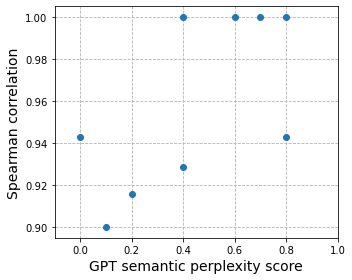

In [189]:
# plot GPT against spearman
x = [b['gpt'] for b in binnings]
y = [b['spearman'] for b in binnings]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(x, y, 'o')
ax.set_xlim([-0.1, 1])
#ax.set_ylim([0, 1])
ax.set_xlabel('GPT semantic perplexity score', fontsize=14)
ax.set_ylabel('Spearman correlation', fontsize=14)
# Set dash style for grid 
ax.grid(True, linestyle='--')
# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(ppath, 'figs', 'gpt_vs_spearman.png'))

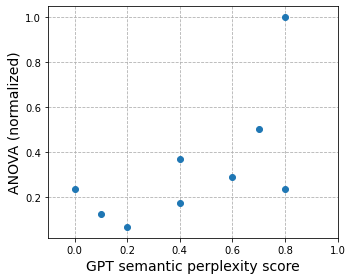

In [199]:
x = [b['gpt'] for b in binnings]
# Normalize ANOVA F-statistic
y = [b['anova'] for b in binnings]
y = [b / (max(y)) for b in y]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(x, y, 'o')
ax.set_xlim([-0.1, 1])
ax.set_xlabel('GPT semantic perplexity score', fontsize=14)
ax.set_ylabel('ANOVA (normalized)', fontsize=14)
# Set dash style for grid 
ax.grid(True, linestyle='--')
# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(ppath, 'figs', 'gpt_vs_anova.png'))

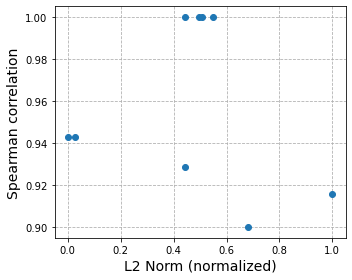

In [205]:
# plot L2 norm against spearman
x = [b['l2_norm'] for b in binnings]
x = [ (b / (max(x))) for b in x]
y = [b['spearman'] for b in binnings]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(x, y, 'o')
ax.set_xlabel('L2 Norm (normalized)', fontsize=14)
ax.set_ylabel('Spearman correlation', fontsize=14)
# Set dash style for grid 
ax.grid(True, linestyle='--')
# Save the plot
plt.tight_layout()
plt.savefig(os.path.join(ppath, 'figs', 'l2_vs_anova.png'))

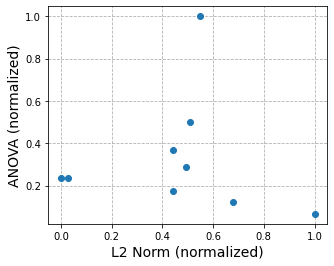

In [204]:
# plot L2 norm against ANOVA
x = [b['l2_norm'] for b in binnings]
x = [ (b / (max(x))) for b in x]
y = [b['anova'] for b in binnings]
y = [b / (max(y)) for b in y]
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(x, y, 'o')
ax.set_xlabel('L2 Norm (normalized)', fontsize=14)
ax.set_ylabel('ANOVA (normalized)', fontsize=14)
# Set dash style for grid
ax.grid(True, linestyle='--')

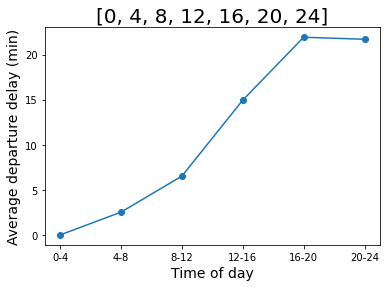

In [210]:
# Plot average departure delay by time of day
data = df.copy()
#data['hour'] = data['sched_dep_time'] // 400
i = 3
data['hour'] = pd.cut(data['hour'], bins=binnings[i]['bins'], labels=binnings[i]['labels'])
data['dep_delay'] = data['dep_delay'].replace(np.nan, 0)
data['dep_delay'] = data['dep_delay'].replace('NA', 0)
data['dep_delay'] = data['dep_delay'].astype(int)
# Average departure delay by time of day
avg_dep_delay = data.groupby('hour')['dep_delay'].mean()
plt.plot(avg_dep_delay, marker='o')
plt.title(f"{binnings[i]['bins']}", fontsize=20)
plt.xlabel('Time of day', fontsize=14)
plt.ylabel('Average departure delay (min)', fontsize=14)
plt.show()

In [123]:
data.groupby('hour')['dep_delay'].count()

hour
0        1
1    77967
2    71234
3    88552
4    84389
5    14633
Name: dep_delay, dtype: int64

In [44]:
from scipy.stats import f_oneway
# Test for difference in average departure delay by time of day
data['hour'] = df['sched_dep_time'] // 100
dep_delay = data.groupby('hour')['dep_delay']
# Convert to list of lists
dep_delay = [group[1] for group in dep_delay]
f_oneway(*dep_delay)

F_onewayResult(statistic=717.8450295084496, pvalue=0.0)

In [142]:
data['hour'] = pd.cut(df['hour'], binnings[1]['bins'], labels=False)
data['dep_delay'] = data['dep_delay'].replace(np.nan, 0)
dep_delay = data.groupby('hour')['dep_delay']
dep_delay = [group[1] for group in dep_delay]
f_oneway(*dep_delay)

F_onewayResult(statistic=1346.8537602888237, pvalue=0.0)

In [93]:
data['hour'] = df['sched_dep_time'] // 1800
dep_delay = data.groupby('hour')['dep_delay']
# Convert to list of lists
dep_delay = [group[1] for group in dep_delay]
dep_delay

[0           2
 1           4
 2           2
 3          -1
 4          -6
          ... 
 336668    182
 336771      0
 336773      0
 336774      0
 336775      0
 Name: dep_delay, Length: 262180, dtype: int64,
 151       853
 630        -2
 631        -2
 634         0
 635         0
          ... 
 336767     -5
 336768     12
 336769    -10
 336770      0
 336772      0
 Name: dep_delay, Length: 74596, dtype: int64]

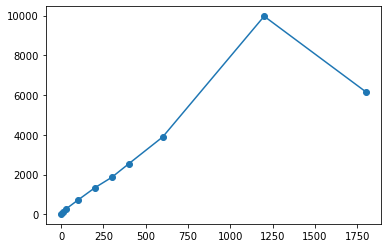

In [92]:
x = []
for i in [1, 10, 30, 100, 200, 300, 400, 600, 1200, 1800]:
    data['hour'] = df['sched_dep_time'] // i
    dep_delay = data.groupby('hour')['dep_delay']
    # Convert to list of lists
    dep_delay = [group[1] for group in dep_delay]
    f, p = f_oneway(*dep_delay)
    x.append((i, f, p))
# plot
plt.plot([i[0] for i in x], [i[1] for i in x], marker='o')
plt.show()

In [72]:
from scipy.stats import spearmanr
# Test for difference in average departure delay by time of day
data['hour'] = df['sched_dep_time'] // 100
dep_delay = data.groupby('hour')['dep_delay'].mean()
spearmanr(dep_delay.index, dep_delay)

SpearmanrResult(correlation=0.9157894736842105, pvalue=1.4853059816575538e-08)

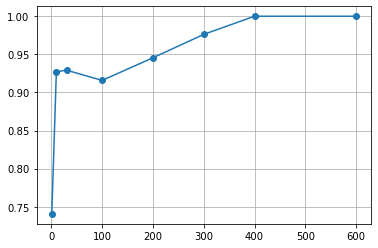

In [89]:
x = []
for i in [1, 10, 30, 100, 200, 300, 400, 600]:
    data['hour'] = df['sched_dep_time'] // i
    dep_delay = data.groupby('hour')['dep_delay'].mean()
    rho, p = spearmanr(dep_delay.index, dep_delay)
    x.append((i, rho, p))
# plot the results
x = np.array(x)
plt.plot(x[:, 0], x[:, 1], marker='o')
plt.grid()
plt.show()